In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from kuma_utils.utils import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import multiprocessing

from datasets import *
from transforms import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [8]:
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
test_summary = pd.read_csv('input/signal_summary.csv')
public748 = pd.read_csv('input/public748.csv')

In [9]:
test = pd.concat([test, test_summary.drop('idx', axis=1)], axis=1)

In [10]:
test

,id,target,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
0,00054c878,0.5,1238170136,1248567118,303,4639,36.596880,5.182469,0.648318,0.236532,1238168574,1248561347,324,4566,31.032060,5.172359,0.646489,0.236746
1,0007285a3,0.5,1238168014,1248520149,319,4427,33.348710,5.185728,0.645892,0.236174,1238169747,1248537247,325,4650,35.349796,5.194143,0.648571,0.237914
2,00076c5a6,0.5,1238168771,1248535146,281,4599,38.125170,5.181007,0.647001,0.236868,1238172441,1248567481,305,4633,35.410625,5.185566,0.646724,0.237244
3,001349290,0.5,1238170698,1248536462,295,4609,33.123688,5.186102,0.646682,0.236379,1238166901,1248536964,322,4621,31.477259,5.177888,0.645992,0.237332
4,001a52e92,0.5,1238166605,1248534994,314,4601,30.006860,5.180545,0.649487,0.237005,1238167190,1248542755,325,4366,31.458930,5.175384,0.647351,0.237881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7970,ffbce04ef,0.5,1238174572,1248548094,332,4533,34.117268,5.175504,0.645922,0.236845,1238173986,1248589023,318,4634,31.854813,5.188142,0.647497,0.237654
7971,ffc2d976b,0.5,1238178719,1248541890,285,4611,35.487473,5.169191,0.647208,0.236513,1238172684,1248539274,285,4730,29.164394,5.183527,0.647657,0.236972
7972,ffc905909,0.5,1238198490,1248582316,290,4726,30.702550,5.180704,0.645512,0.236194,1238171186,1248563155,302,4619,31.855278,5.190749,0.646872,0.236676
7973,ffe276f3e,0.5,1238167796,1248534967,307,4520,34.794548,5.182399,0.649433,0.238161,1238167002,1248535419,305,4533,31.888836,5.174247,0.649748,0.237436


# Correlation

In [ ]:
# model_paths = [
#     Path('results/aug_15_bu/'), # 733
#     Path('results/aug_11_ds1/'), # 723
#     Path('results/aug_11/'), # 719
# ]
model_paths = [
    # Path('results/baseline_3/'),
    # Path('results/ds_02_prep0'),
    # Path('results/ds_04'),
    # Path('results/aug_01'),
    # Path('results/aug_01_prep0'),
    # Path('results/aug_02'),
    # Path('results/aug_03'),
    # Path('results/aug_04'),
    # Path('results/ds_05'),
    # Path('results/ds_05_aug0'),
    # Path('results/ds_05_aug1'),
    # Path('results/ds_05_aug2'),
    # Path('results/ds_06/'),
    # Path('results/ds_07/'),
    # Path('results/ds_08/'),
    # Path('results/model_00/'),
    Path('results/ds_09/'),
    # Path('results/ds_12/'),
    Path('results/ds_13/'),
    # Path('results/res_00'),
    # Path('results/res_02')
    # Path('results/aug_01'),
    # Path('results/aug_02'),
    # Path('results/ds_09_mod0'),
    # Path('results/ds_09_mod1'),
    # Path('results/mixup_00'),
    # Path('results/mixup_01'),
    # Path('results/mixup_03'),
    # Path('results/chris_v16'),
    Path('results/ds_09_val1'),
    Path('results/aug_04'),
]


In [ ]:
prediction_df = {}
for p in model_paths:
    if (p/'predictions_tta_wo_anomaly.npy').exists():
        prediction_df[p.stem] = sigmoid(np.load(p/'predictions_tta_wo_anomaly.npy')).reshape(-1)
    else:
        pred = sigmoid(np.load(p/'predictions_tta.npy'))
        print(pred.shape)
        if pred.shape[1] == 1:
            pred = pred.reshape(-1)
        elif pred.shape[0] == 5:
            pred = pred[0].reshape(-1)
        prediction_df[p.stem] = pred
prediction_df = pd.DataFrame(prediction_df)
# prediction_df['public748'] = public748['target'].values
# prediction_df['public716'] = public716['target'].values

In [ ]:
model_names = prediction_df.columns
prediction_df

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(prediction_df.corr(), square=True, annot=True)
plt.show()

# Error analysis

In [ ]:
prediction_df['rank_std'] = prediction_df.rank(0).std(1)

In [ ]:
sns.histplot(prediction_df['rank_std'])

In [ ]:
prediction_df = pd.concat([prediction_df, test], axis=1)

In [ ]:
prediction_df_easy = prediction_df.sort_values('rank_std')
Path('input/plot/easy/').mkdir(parents=True, exist_ok=True)
ds = G2Net2022Dataset3(
    prediction_df_easy.head(100),
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    # transforms=ClipSignal(0, 1.5)
)
for idx, (specs, _) in enumerate(ds):
    gid = ds.df.iloc[idx]['id']
    labels = ds.df[model_names].iloc[idx]
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx}, {np.round(labels.values, 2)}')
    plt.subplot(1, 4, 1)
    plt.imshow(specs[:, :, 0])
    plt.title('H1')
    plt.subplot(1, 4, 2)
    plt.imshow(specs[:, :, 1])
    plt.title('L1')
    plt.subplot(1, 4, 3)
    col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
    col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
    plt.plot(specs[:, col_roi0, 0])
    plt.plot(specs[:, col_roi1, 1])
    plt.title(f'time slice ({col_roi0}/{col_roi1})')
    plt.subplot(1, 4, 4)
    row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
    row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
    plt.plot(specs[row_roi0, :, 0])
    plt.plot(specs[row_roi1, :, 1])
    plt.title(f'freq slice ({row_roi0}/{row_roi1})')
    plt.savefig(f'input/plot/easy/{gid}.png', facecolor='white')
    plt.close()
    # plt.show()


In [ ]:
prediction_df_hard = prediction_df.sort_values('rank_std', ascending=False)
Path('input/plot/hard/').mkdir(parents=True, exist_ok=True)
ds = G2Net2022Dataset3(
    prediction_df_hard.head(100),
    # prediction_df.loc[prediction_df['id'].isin(["040b35321", "09d7ea37a", "081ee0aea", "025517630"])],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    transforms=ClipSignal(0, 1.5)
    # transforms=A.Compose([
    #     ClipSignal(0, 1.5),
    #     BandNoise(strength=0.25, p=1.0)
    # ])
    # transforms=ClipSignal(0, 1)
    # transforms=BandNoise(p=1.0)
    # transforms=DeltaNoise(channel='both', strength=(500, 4000), p=1),
    # transforms=MixupChannel(fix_area=True, p=1),
    # transforms=MixupChannel2(256, p=1)
)
for idx, (specs, _) in enumerate(ds):
    gid = prediction_df_hard.iloc[idx]['id']
    labels = prediction_df_hard[model_names].iloc[idx]
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx}, {np.round(labels.values, 2)}')
    plt.subplot(1, 4, 1)
    plt.imshow(specs[:, :, 0])
    plt.title('H1')
    plt.subplot(1, 4, 2)
    plt.imshow(specs[:, :, 1])
    plt.title('L1')
    plt.subplot(1, 4, 3)
    col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
    col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
    plt.plot(specs[:, col_roi0, 0])
    plt.plot(specs[:, col_roi1, 1])
    plt.title(f'time slice ({col_roi0}/{col_roi1})')
    plt.subplot(1, 4, 4)
    row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
    row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
    plt.plot(specs[row_roi0, :, 0])
    plt.plot(specs[row_roi1, :, 1])
    plt.title(f'freq slice ({row_roi0}/{row_roi1})')
    plt.savefig(f'input/plot/hard/{gid}.png', facecolor='white')
    plt.close()
    # plt.show()

In [ ]:
# ds = G2Net2022Dataset3(
#     prediction_df.query('max_h1 < 350').sort_values('25%_h1', ascending=False).head(5),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
#     preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
#     transforms=ClipSignal(0, 1.5)
# )
# for idx, (specs, _) in enumerate(ds):
#     gid = ds.df.iloc[idx]['id']
#     labels = ds.df[model_names].iloc[idx].values
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx}, {np.round(labels, 2)}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[:, :, 0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[:, :, 1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
#     col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
#     plt.plot(specs[:, col_roi0, 0])
#     plt.plot(specs[:, col_roi1, 1])
#     plt.title(f'time slice ({col_roi0}/{col_roi1})')
#     plt.subplot(1, 4, 4)
#     row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
#     row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
#     plt.plot(specs[row_roi0, :, 0])
#     plt.plot(specs[row_roi1, :, 1])
#     plt.title(f'freq slice ({row_roi0}/{row_roi1})')
#     plt.show()

In [ ]:
# ds = G2Net2022Dataset3(
#     pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v18v.csv').tail(10),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v18v'),
#     # match_time=True,
#     preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
#     transforms=A.Compose([
#         CropImage(256), 
#         # InjectTimeNoise('input/timenoise_v1.pickle', resize_factor=16, strength=(0.9, 1.5), p=1.),
#         # InjectAnomaly('input/anomaly_v0_16.pickle', 'H1', p=1.),
#         # InjectAnomaly('input/anomaly_v0_16.pickle', 'L1', p=1.)
#         ])
# )
# for idx, (specs, _) in enumerate(ds):
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[:, :, 0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[:, :, 1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
#     col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
#     plt.plot(specs[:, col_roi0, 0])
#     plt.plot(specs[:, col_roi1, 1])
#     plt.title(f'time slice ({col_roi0}/{col_roi1})')
#     plt.subplot(1, 4, 4)
#     row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
#     row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
#     plt.plot(specs[row_roi0, :, 0])
#     plt.plot(specs[row_roi1, :, 1])
#     plt.title(f'freq slice ({row_roi0}/{row_roi1})')
#     plt.show()
#     plt.close()

In [12]:
%matplotlib inline

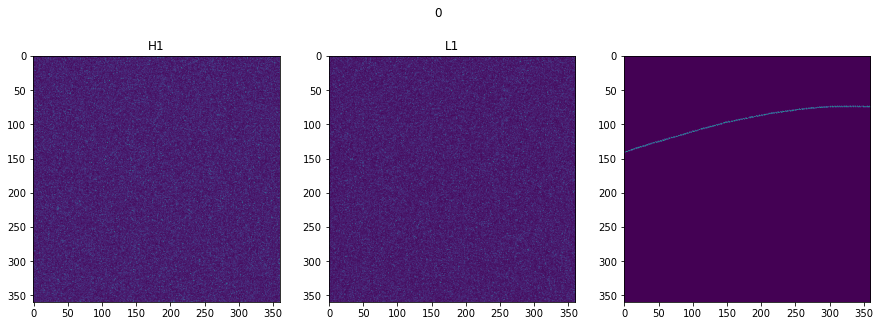

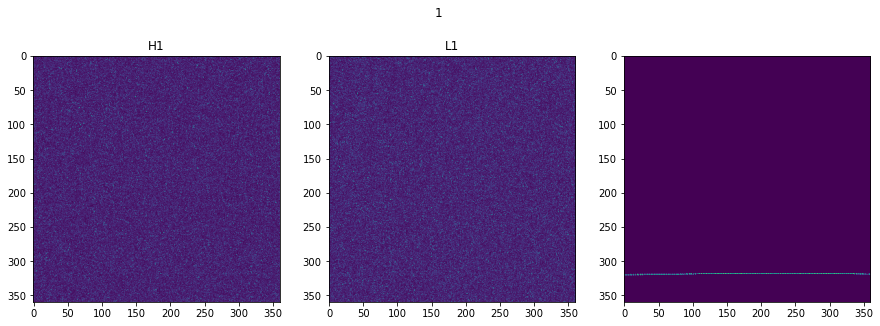

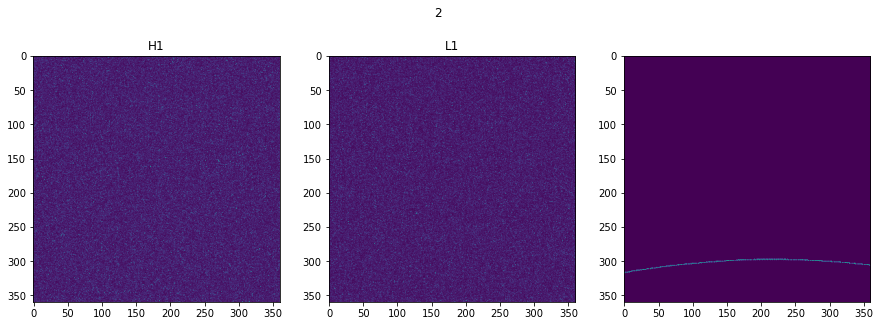

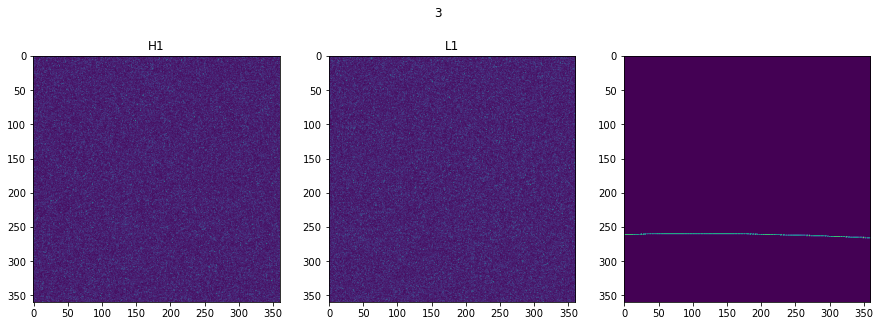

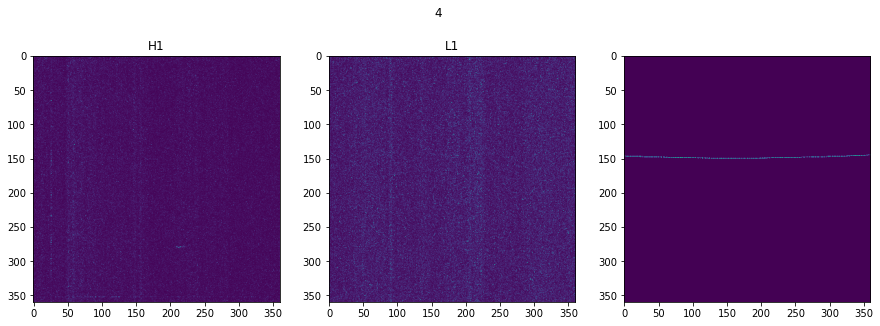

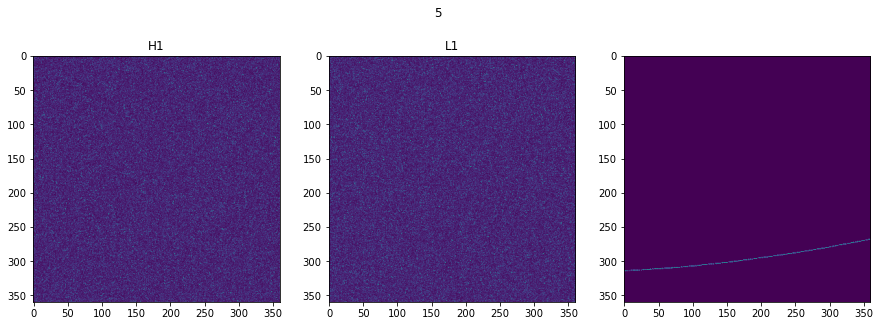

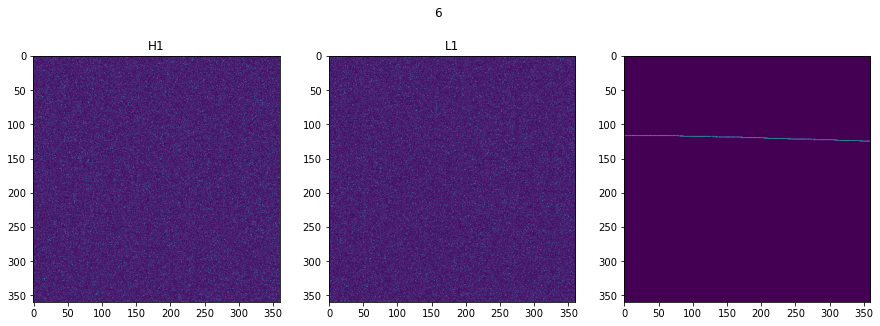

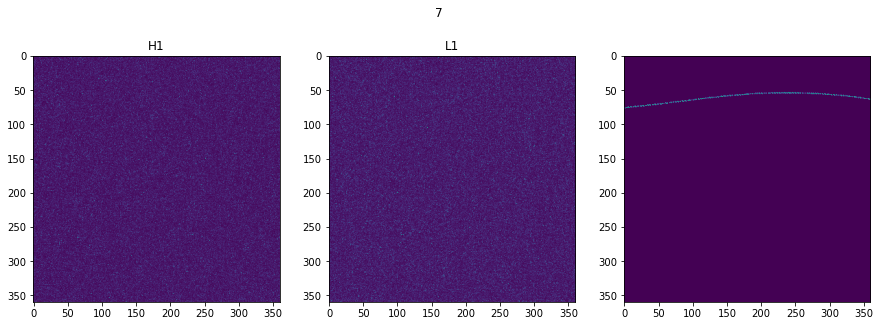

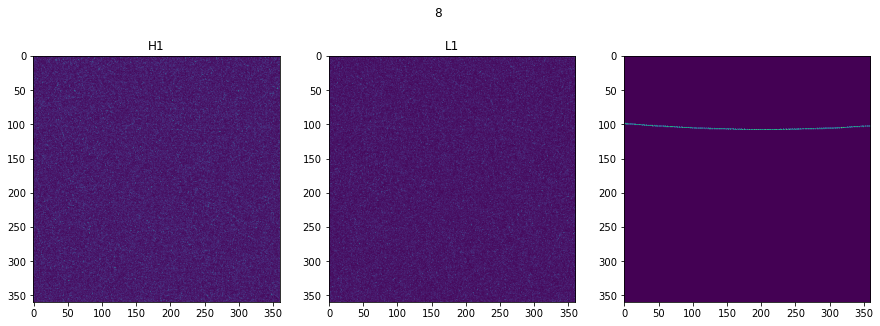

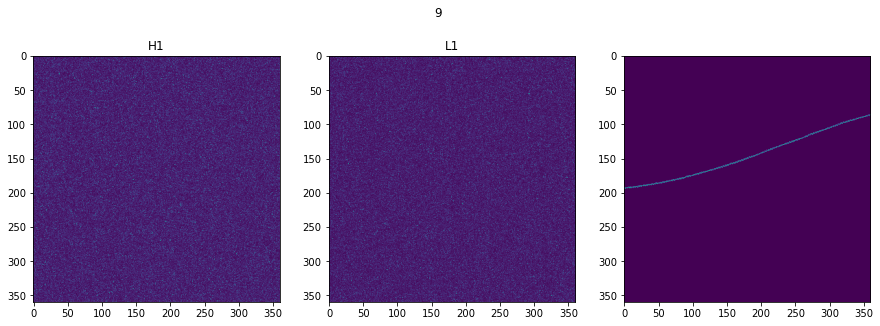

In [17]:
# ds = G2Net2022Dataset88(
#     df=pd.read_csv(Path('input/g2net-detecting-continuous-gravitational-waves/v18s.csv')).head(10),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v18s'),
#     noise_path=Path('input/g2net-detecting-continuous-gravitational-waves/concat_v18n1_v18n2.csv'),
#     noise_dir=None,
#     match_time=False,
#     signal_amplifier=1,
#     shift_range=(-165, 165),
#     positive_p=1,
#     noise_mixup_p=0,
#     return_mask=True,
#     # is_test=True,
#     preprocess=A.Compose([
#         ToSpectrogram(), 
#         AdaptiveResize(img_size=360), 
#         NormalizeSpectrogram('constant')]),
#     transforms=None
# )
# for idx, (specs, mask, _) in enumerate(ds):
#     plt.figure(figsize=(15, 5))
#     plt.suptitle(f'{idx}')
#     plt.subplot(1, 3, 1)
#     plt.imshow(specs[:, :, 0])
#     plt.title('H1')
#     plt.subplot(1, 3, 2)
#     plt.imshow(specs[:, :, 1])
#     plt.title('L1')
#     plt.subplot(1, 3, 3)
#     plt.imshow(mask)
#     plt.show()
#     # plt.savefig(f'input/plot/sample/{idx}.png', facecolor='white')
#     plt.close()

# Analyse artifact

In [ ]:
from torchvision.ops import masks_to_boxes
import cv2

In [ ]:
anomaly_h1 = [
    "5b3eb27e1", "7ee0a00f8", '55dd4d584', '67e294a77', '80b695868', '1739abf41',
    '698567d90', '6735074ac', 'acc728828', 'b7ec2f672', 'b69313a43', 'b0990161d',
    'b95698658', 'fd0bde745', 'fe3005e83', '17ed59f7a', '38a84a185', '040b35321',
    'c5cd03dc9'
    ]
anomaly_l1 = ['8b180f74f', 'a1f9b8e82', 'dc2aaaee9', 'dee7c8d0f', 'f00d2044a']

In [ ]:
# ds = G2Net2022Dataset3(
#     test.loc[test['id'].isin(anomaly_h1+anomaly_l1)].head(10),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
#     # preprocess=A.Compose([
#     #     ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
#     # transforms=ToTensorV2()
#     match_time=False,
#     preprocess=A.Compose([
#         ToSpectrogram(), AdaptiveResize(img_size=360), 
#         NormalizeSpectrogram('constant')
#     ]),
#     transforms=A.Compose([
#         # RandomCrop(256),
#         ToTensorV2(), RemoveAnomaly()
#     ]),
# )
# for idx, (specs, _) in enumerate(ds):
#     gid = ds.df.iloc[idx]['id']
#     specs_std = specs.std(dim=(1, 2))
#     specs_min = specs.amin(dim=(1, 2))
#     amp_map = (specs - specs_min[:, None, None]) / specs_std[:, None, None]
#     plt.imshow((amp_map > 10).to(torch.uint8)[0])
#     plt.show()
#     specs_max = specs.amax(dim=(1, 2))
#     print((specs_max - specs_min) / specs_std)
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx} {gid}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     plt.plot(specs[0, :, 128])
#     plt.plot(specs[1, :, 128])
#     plt.title('time slice')
#     plt.subplot(1, 4, 4)
#     plt.plot(specs[0, 180, :])
#     plt.plot(specs[1, 180, :])
#     plt.title('freq slice')
#     plt.show()
#     plt.close()

In [ ]:
def get_anomaly(spec, threshold=1.5):
    anomaly_mask = spec > threshold
    if anomaly_mask.sum() > 0:
        anomaly_bbox = masks_to_boxes(anomaly_mask[None, :, :])[0]
        xmin, ymin, xmax, ymax = anomaly_bbox.to(int)
        return spec[
            max(ymin-5, 0):min(ymax+5, spec.shape[1]), 
            max(xmin-5, 0):min(xmax+5, spec.shape[0])]
    else:
        None


def parse_anomaly(anomaly):
    anomaly = anomaly.numpy()
    anomaly[anomaly < 0.5] = 0
    strength = anomaly.max()
    anomaly = (anomaly - anomaly.min()) / (anomaly.max() - anomaly.min())
    return anomaly, strength

In [ ]:
anomaly_dict = {
    'H1': [], 'L1': []
}

In [ ]:
ds = G2Net2022Dataset3(
    test.loc[test['id'].isin(anomaly_h1)],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([
        ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    transforms=ToTensorV2()
)

for specs, _ in ds:
    anomaly = get_anomaly(specs[0], 1.5)
    if anomaly is not None:
        if anomaly.shape[0] * anomaly.shape[1] < 1500:
            continue
        # plt.figure(figsize=(8, 4))
        # plt.subplot(1, 2, 1)
        # plt.imshow(specs[0])
        # plt.subplot(1, 2, 2)
        # plt.imshow(anomaly)
        # plt.show()
        anomaly, strength = parse_anomaly(anomaly)
        if anomaly is not None:
            anomaly_dict['H1'].append((anomaly, strength))

In [ ]:
ds = G2Net2022Dataset3(
    test.loc[test['id'].isin(anomaly_l1)],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([
        ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    transforms=ToTensorV2()
)

for specs, _ in ds:
    anomaly = get_anomaly(specs[1], 1.5)
    if anomaly is not None:
        if anomaly.shape[0] * anomaly.shape[1] < 1500:
            continue
        # plt.figure(figsize=(8, 4))
        # plt.subplot(1, 2, 1)
        # plt.imshow(specs[0])
        # plt.subplot(1, 2, 2)
        # plt.imshow(anomaly)
        # plt.show()
        anomaly, strength = parse_anomaly(anomaly)
        if anomaly is not None:
            anomaly_dict['L1'].append((anomaly, strength))

In [ ]:
with open('input/anomaly_v0_16.pickle', 'wb') as f:
    pickle.dump(anomaly_dict, f)

# Generate Noise Template

In [ ]:
timenoise_idx = [
    # v0
    '0a9ab0c9e', '0de7c7655', '0e9c2bb33', '1dc9bc740', '1facb0bab', '6b4107dfd', 
    '6ba4c8187', '6ec448e76', '7a1668972', '7dc03113e', '8bfb5c3fe', '8c0e4381a',
    '8f0d3c49c', '64bf3b4cc', '80ce2df12', '250ce99ba', '343fd1262', '371a20194',
    '439ff8b8c', '500ca9751', '838ca3d9e', '8537d2f36', '8603bf1e2', '961624e88',
    '2705507a9', '5310205bd', '38994676c', '82991740d', '227585724', 'a0eeec887',
    'ae967aea1', 'b4c72f14d', 'b176dfe31', 'b267c820d', 'b383cdb39', 'b604b31b5',
    'cdc0d65cb', 'cdeb7fe4a', 'd5b7bf6e3', 'd94f90817', 'e2c46e48a', 'e0696d220',
    'ef559e2d9', 'efb2e3891', 'f090b5877', 
    # v1
    '3da1e0f33', '9c0b5f798', '1928ca4a7', 'a9e280d75', 'dcdf0f575', 
    # v2
    '64a563381', 'df7f170d3', '0a1a06b36', '3bcc523a3', 'e4d6595d9',
    'd93435874', 'b829c1194', '65e192431', 'ceafe2326', 'da86f97af',
    '1b96f2483', 'b7a3bfd36', '5ffa7a8f4', '41154b5f0', '2dbea30b0',
    'd794f8f4e', 'd4e46b35f', '634543900'
]
timenoise_idx = set(timenoise_idx)
ds = G2Net2022Dataset3(
    test.loc[test['id'].isin(timenoise_idx)],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([
        ToSpectrogram(), NormalizeSpectrogram('constant')]),
)

In [ ]:
def extract_noise_template(specs):
    spec_h1, specs_l1 = specs[:, :, 0], specs[:, :, 1]
    return spec_h1.mean(0), specs_l1.mean(0)

In [ ]:
noise_templates = {
    'H1': [],
    'L1': [],
}
for idx, (specs, _) in enumerate(ds):
    tmp_h1, tmp_l1 = extract_noise_template(specs)
    noise_templates['H1'].append(tmp_h1)
    noise_templates['L1'].append(tmp_l1)


In [ ]:
with open('input/timenoise_v2.pickle', 'wb') as f:
    pickle.dump(noise_templates, f)

# Training visualization

In [ ]:
from configs import *
from configs_chris import *

In [ ]:
# ds = cfg.dataset(
#     pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v12.csv').head(10),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v12'),
#     # transforms=cfg.transforms['train'],
#     transforms=A.Compose([
#         RandomCrop(4096),
#         BandPass(sr=2048),
#         WaveToTensor()]),
#     **cfg.dataset_params
# )

In [ ]:
cfg = Ds09()
ds = cfg.dataset(
    pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/concat_v13_v14_v15.csv').tail(10),
    # match_time=True,
    preprocess=A.Compose([
        ToSpectrogram(), AdaptiveResize(16), 
        NormalizeSpectrogram('column_wise')
    ]),
    transforms=A.Compose([
        RandomCrop(256),
        ToTensorV2()
    ]),
    # transforms=cfg.transforms['train'],
    # **dict(cfg.dataset_params, **{'match_time': True})
)

In [ ]:
# for idx, inputs in enumerate(ds):
#     specs = inputs[0]
#     specs = (specs - specs.min()) / (specs.max() - specs.min())
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     plt.plot(specs[0, :, 128])
#     plt.plot(specs[1, :, 128])
#     plt.title(f'time slice')
#     plt.subplot(1, 4, 4)
#     plt.plot(specs[0, 180, :])
#     plt.plot(specs[1, 180, :])
#     plt.title(f'freq slice')
#     plt.show()
#     if idx == 10:
#         break
    

In [ ]:
# for idx, (wave, _) in enumerate(ds):
#     print(wave.shape)
#     plt.plot(wave[0, :100])
#     plt.show()
#     break
    

# Noise matching

In [ ]:
from data_gen.prep_data_v17 import bucketize_real_noise_asd
from sklearn.metrics.pairwise import cosine_similarity 
from tslearn import metrics

In [ ]:
import tslearn

In [ ]:
asd_h1 = []
# asd_l1 = []
for gid in tqdm(test['id'].values):
    with open(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle', 'rb') as f:
        data = pickle.load(f)
    asd_h1.append(bucketize_real_noise_asd(data[gid]['H1']['SFTs'], data[gid]['H1']['timestamps_GPS'], 256)[0])
    # asd_l1.append(bucketize_real_noise_asd(data[gid]['L1']['SFTs'], data[gid]['L1']['timestamps_GPS'], 256)[0])
asd_h1 = np.stack(asd_h1, axis=0)
# asd_l1 = np.stack(asd_l1, axis=0)
asd_h1 *= 1e22


In [ ]:
dtw_sim = np.zeros((len(asd_h1), len(asd_h1)), dtype=float)

# def calc_dtw(a, b, sim):
#     sim[]

# for i in tqdm(range(len(asd_h1))):
for i in tqdm(range(100)):
    for j in range(len(asd_h1)):
        if i >= j:
            continue
        else:
            dtw_sim[i, j] = metrics.dtw_path(asd_h1[i], asd_h1[j])[1]


In [ ]:
dtw_sim[dtw_sim == 0] = 1000
dtw_sim.min(1)[:100]

In [ ]:
gap_pattern_h1 = []
gap_pattern_l1 = []
for gid in tqdm(test['id'].values):
    with open(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle', 'rb') as f:
        data = pickle.load(f)
    gap_pattern_h1.append(data[gid]['H1']['timestamps_GPS'])
    gap_pattern_l1.append(data[gid]['L1']['timestamps_GPS'])


In [ ]:
test

In [ ]:
ts_all = {}
for ts_r in gap_pattern_h1:
    for ts in ts_r:
        if ts in ts_all.keys():
            ts_all[ts] += 1
        else:
            ts_all[ts] = 0

In [ ]:
ts_all = pd.DataFrame.from_dict(ts_all, 'index')

In [ ]:
ts_all.head(10000).plot(figsize=(15, 4), alpha=0.5)

In [ ]:
dtw_sim = np.zeros((len(gap_pattern_h1), len(gap_pattern_h1)), dtype=float)

# def calc_dtw(a, b, sim):
#     sim[]

# for i in tqdm(range(len(gap_pattern_h1))):
for i in tqdm(range(100)):
    for j in range(len(gap_pattern_h1)):
        if i >= j:
            continue
        else:
            dtw_sim[i, j] = metrics.dtw_path(gap_pattern_h1[i], gap_pattern_h1[j])[1]


In [ ]:
slopes = np.array([(ts[-1] - ts[0]) / len(ts) for ts in gap_pattern_h1])

In [ ]:

for i in range(len(slopes)):
    j = np.argsort(np.abs((slopes - slopes[i])))[1]
    score = np.abs(gap_pattern_h1[i][1000:2000] - gap_pattern_h1[j][1000:2000]).mean()
    if score < 1000:
        print(i, j, score)

In [ ]:
np.argsort(np.abs((slopes - slopes[5160])))

In [ ]:
plt.plot(gap_pattern_h1[5160], alpha=0.5)
plt.plot(gap_pattern_h1[7205], alpha=0.5)

In [ ]:
gaps = np.stack([(gap_pattern_h1[i][1:] - (gap_pattern_h1[i][:-1] + 1800))[:4096] for i in range(len(gap_pattern_h1))])

In [ ]:
for idx in test.query('1238160000 < ts_start_h1 < 1238170000').index[:20]:
    plt.plot(gaps[idx] / 1800, alpha=0.2)
plt.show()

In [ ]:
with open('input/g2net-detecting-continuous-gravitational-waves/v13/00a0beb7d_strong.pickle', 'rb') as f:
    data = pickle.load(f)['00a0beb7d_strong']

In [ ]:
ts = data['H1']['timestamps_GPS']
plt.plot(ts[1:]-ts[:-1]-1800)
plt.show()

In [ ]:
sample_gaps = np.stack([gap_pattern_h1[idx] for idx in test_summary.query('num_gaps_h1 == 308 and length_h1 == 4586').index], axis=0)

In [ ]:
test_summary.query('num_gaps_h1 == 308 and length_h1 == 4586')

In [ ]:
sample_gaps = np.stack([gap_pattern_h1[idx] for idx in test_summary.query('num_gaps_h1 == 308 and length_h1 == 4586').index], axis=0)

In [ ]:
test.query('ts_start_h1 == 1238167615')

In [ ]:
ds = G2Net2022Dataset3(
    # test.query('ts_start_h1 == 1238167615'),
    test.iloc[[14, 7569]],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    # preprocess=A.Compose([
    #     ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    # transforms=ToTensorV2()
    preprocess=A.Compose([
        ToSpectrogram(), NormalizeSpectrogram('constant')
    ]),
    transforms=A.Compose([
        ToTensorV2()
    ]),
    match_time=True
)
for idx, (specs, _) in enumerate(ds):
    gid = ds.df.iloc[idx]['id']
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx} {gid}')
    plt.subplot(1, 4, 1)
    plt.imshow(specs[0])
    plt.title('H1')
    plt.subplot(1, 4, 2)
    plt.imshow(specs[1])
    plt.title('L1')
    plt.subplot(1, 4, 3)
    plt.plot(specs[0, :, 128])
    plt.plot(specs[1, :, 128])
    plt.title('time slice')
    plt.subplot(1, 4, 4)
    plt.plot(specs[0, 180, :])
    plt.plot(specs[1, 180, :])
    plt.title('freq slice')
    plt.show()
    plt.close()
    # plt.savefig(f'test/{idx}.png', facecolor='white')
    # plt.close()
    if idx == 10:
        break